### 1. Preliminaries

In [16]:
try: import fastkaggle

except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

competition = 'paddy-doctor-diseases-v2'
path = setup_comp(competition, install='fastai "timm>=0.6.2.dev0"')

from fastai.vision.all import *
set_seed(42)

# train images
train_path = path / 'train_images'
train_files = get_image_files(train_path)

# test images
test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()

# train labels
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

### 2. Dataloaders

In [20]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

In [21]:
dls = ImageDataLoaders.from_folder(
    train_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

### 3. Model training

In [23]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

And that's it, 16 epochs to get the best baseline for the price 

In [24]:
#learn.fine_tune(16, 0.005)
learn.fine_tune(2, 0.005)

epoch,train_loss,valid_loss,error_rate,time
0,1.818072,1.056468,0.331279,03:43


epoch,train_loss,valid_loss,error_rate,time
0,0.754003,0.460287,0.149076,03:37
1,0.344703,0.224405,0.076271,03:36


### 4. Predictions

In [25]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0763)

### Predictions on test set

In [57]:
# test images
test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()
test_classes = [f.parent.name for f in test_files]

probs, _ = learn.tta(dl=dls.test_dl(test_files))
preds = probs.argmax(dim=1)
pred_classes = dls.vocab[preds]

In [76]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

cls_report = classification_report(test_classes, pred_classes, 
                                   digits=5)
print(cls_report)
acc = accuracy_score(test_classes, pred_classes)

                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.93388   0.86923   0.90040       130
   bacterial_leaf_streak    0.93069   0.94000   0.93532       100
bacterial_panicle_blight    0.97701   0.94444   0.96045        90
        black_stem_borer    0.98947   0.93069   0.95918       101
                   blast    0.95075   0.94468   0.94771       470
              brown_spot    0.94606   0.90119   0.92308       253
            downy_mildew    0.88953   0.87931   0.88439       174
                   hispa    0.90583   0.93735   0.92132       431
             leaf_roller    0.92202   0.91781   0.91991       219
                  normal    0.95732   0.97921   0.96814       481
                  tungro    0.93267   0.95897   0.94564       390
        white_stem_borer    0.95312   0.96063   0.95686       254
       yellow_stem_borer    0.97297   0.94737   0.96000       152

                accuracy                        0.93960      3245
        

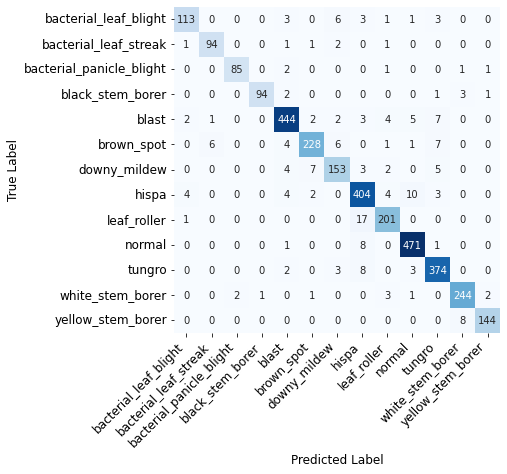

[[113   0   0   0   3   0   6   3   1   1   3   0   0]
 [  1  94   0   0   1   1   2   0   1   0   0   0   0]
 [  0   0  85   0   2   0   0   0   1   0   0   1   1]
 [  0   0   0  94   2   0   0   0   0   0   1   3   1]
 [  2   1   0   0 444   2   2   3   4   5   7   0   0]
 [  0   6   0   0   4 228   6   0   1   1   7   0   0]
 [  0   0   0   0   4   7 153   3   2   0   5   0   0]
 [  4   0   0   0   4   2   0 404   4  10   3   0   0]
 [  1   0   0   0   0   0   0  17 201   0   0   0   0]
 [  0   0   0   0   1   0   0   8   0 471   1   0   0]
 [  0   0   0   0   2   0   3   8   0   3 374   0   0]
 [  0   0   2   1   0   1   0   0   3   1   0 244   2]
 [  0   0   0   0   0   0   0   0   0   0   0   8 144]]


In [84]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_names = dls.vocab
plot_heatmap(test_classes, pred_classes, class_names, ax, title="Resnet34")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(test_classes, pred_classes)
print(cm)

#### Acknowledgements
1. https://www.kaggle.com/code/fmussari/fast-resnet34-with-fastai
